In [1]:
import sys

In [2]:
sys.path.append("..")

In [90]:
import torch
import torch_geometric as tg

import networkx as nx
import numpy as np

from torch_geometric.data import Data, Batch
from src.model.springmodel import SpringModel
from src.data_generater.spring import SpringSim

import matplotlib.pyplot as plt

# 1. One-step Prediction 

In [91]:
def batch(batch_size, n_balls=10):
    model = SpringSim(n_balls=n_balls)
    pos, vel, adj = model.sample_trajectory((1+batch_size)*100)

    G = nx.from_numpy_array(adj)
    edge_index = torch.LongTensor(np.array(G.edges()).T)
    edge_index = tg.utils.to_undirected(edge_index)
    
    data_list = []
    for b in range(batch_size):
        pos_f = torch.Tensor(pos[b].T)
        pos_n = torch.Tensor(pos[b+1].T)
        vel_f = torch.Tensor(vel[b].T)
        vel_n = torch.Tensor(vel[b+1].T)

        data = Data(num_nodes=n_balls,
                    edge_index=edge_index, 
                    pos_f=pos_f,
                    pos_n=pos_n,
                    vel_f=vel_f,
                    vel_n=vel_n)
        data_list.append(data)
    batch = Batch.from_data_list(data_list)
    return batch

In [92]:
# args
cuda_id = "cuda:0"
batch_size = 64
pos_in_dim = 2
vel_in_dim = 2
edge_in_dim = 4
hid_dim = 64
n_balls = 10

In [93]:
device = torch.device(cuda_id)
model = SpringModel(pos_in_dim, edge_in_dim, vel_in_dim, hid_dim)
model = model.to(device)
model.load_state_dict(torch.load("../checkpoints/spring_base_model.pt"))
model.eval()

SpringModel(
  (pos_encoder): PositionEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (edge_encoder): EdgeEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (vel_encoder): VelocEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (process): Processer(
    (encoder): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
   

In [94]:
batch_size = 100

In [95]:
val_batch = batch(batch_size, n_balls=10).to(device)
pos_pred, vel_pred = model(val_batch)

/home/philip/anaconda3/envs/control/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [96]:
pos_pred_traj = []
for i in range(batch_size):
    pos = pos_pred[i*10:(i+1)*10].detach().cpu().numpy()
    pos_pred_traj.append(pos)
pos_pred_traj = np.array(pos_pred_traj)

In [97]:
pos_true_traj = []
for i in range(batch_size):
    pos =val_batch.pos_n[i*10:(i+1)*10].detach().cpu().numpy()
    pos_true_traj.append(pos)
pos_true_traj = np.array(pos_true_traj)

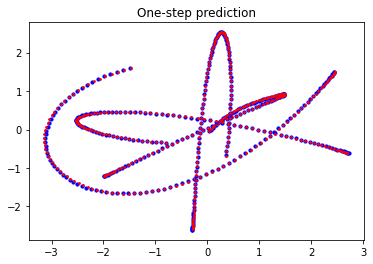

In [103]:
fig, ax = plt.subplots()
for i in  [2,5,8,9]:
    ax.scatter(pos_true_traj[:, i, 0], pos_true_traj[:, i, 1], s=10, c="b")
    ax.scatter(pos_pred_traj[:, i, 0], pos_pred_traj[:, i, 1], s=3, c="r")
ax.set_title("One-step prediction")
fig.savefig("../figs/one_step_predict.pdf")

# 2. Multi-Step prediction 

In [99]:
model.eval()
multi_step_pred = []
pre_pred  = None
for data in val_batch.to_data_list()[1:]:
    if pre_pred is not None:
        data.pos_f = pre_pred
    pos_pred, _ = model(data)
    pre_pred = pos_pred
    multi_step_pred.append(pos_pred.detach().cpu().numpy())

In [100]:
multi_step_pred = np.array(multi_step_pred)

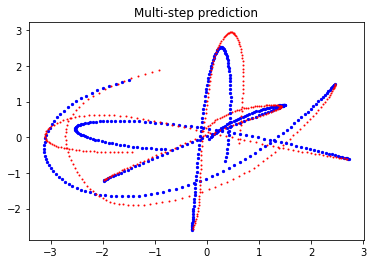

In [102]:
fig, ax = plt.subplots()
for i in [2,5,8,9]:
    ax.scatter(pos_true_traj[1:, i, 0], pos_true_traj[1:, i, 1], s=5, c="b")
    ax.scatter(multi_step_pred[:, i, 0], multi_step_pred[:, i, 1], s=1, c="r")
ax.set_title("Multi-step prediction")
fig.savefig("../figs/multi_step_predict.pdf")